## HW 2
#### Hong Won Jang, Yuqi Niu, Ruisi Liu, Matthew Yang

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
url = 'https://raw.githubusercontent.com/matthewyang123/Booth-ML/main/Bike_test.csv'
test = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/matthewyang123/Booth-ML/main/Bike_train.csv'
train = pd.read_csv(url)

### Question 1

**a. Visualize the relationship between count and the following variables: windspeed, humidity, temp, and atemp**

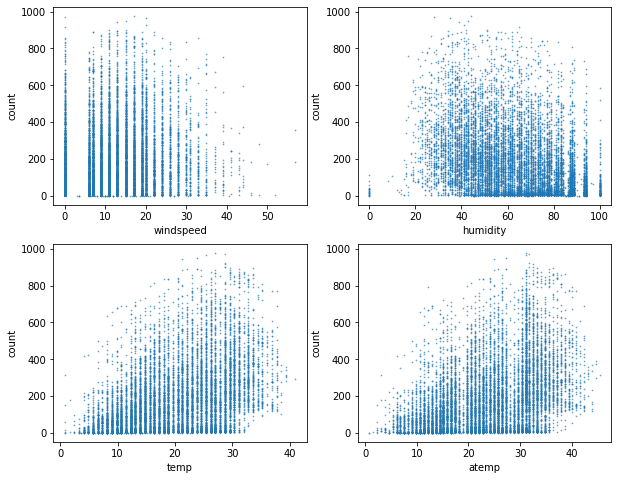

In [ ]:
visual_vrs = ["windspeed", "humidity", "temp", "atemp"]
plt.subplots(2,2, figsize=(10,8))
for idx, visual_vr in enumerate(visual_vrs): 
    plt.subplot(2, 2, idx+1)
    plt.scatter(x = visual_vr, y = "count", s=0.5, alpha = 0.6, data = train)
    plt.xlabel(visual_vr); plt.ylabel("count")  

**b. Visualize the relationship between count and season**

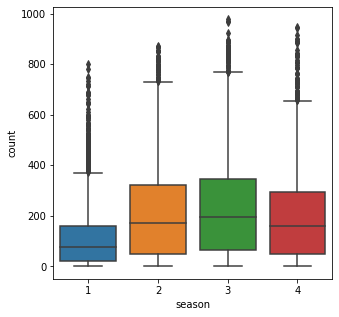

In [ ]:
plt.figure(figsize=(5,5))
fig = sns.boxplot(x = "season", y="count", data=train)
plt.show()

From the boxplots above, we see that bike rentals are lowest in the the winter and highest in summer. There are almost as many rentals in the spring and fall as in the summer. This is consistent with our intuition.

**c. Visualize the relationship between count and hour, by working day and temperature**

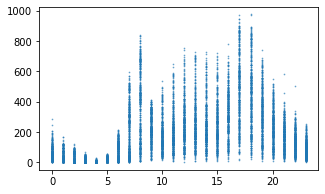

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(x="hour", y="count", s=0.5, alpha = 0.6, data=train)
plt.show()

The hourly count plot above shows that bike rentals vary a lot based on the time of day. Specifically, rentals peak in the early morning (around 8 am) and early evening (around 5 pm), which coincides with commuting times. Below, we investigate how this hourly distribution is different on working days vs non-working days. We see that on non-working days, the number of rentals reaches peak from 12pm to 5pm, whereas on working days the rentals peak at commuting times. Furthermore, rentals tend to be higher on warmer days as the plots below show.

In [ ]:
import matplotlib.colors as mcol
import matplotlib.cm as cm
cm = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
cnorm = mcol.Normalize(vmin=0,vmax=45)

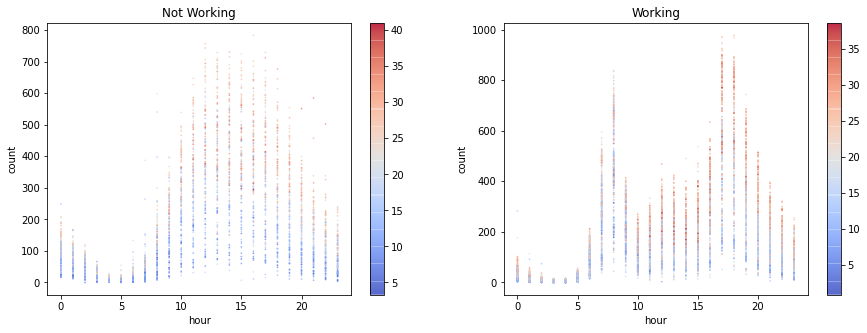

In [ ]:
plt.subplots(1,2, figsize=(15,5))
work_dict = {1:"Working", 0: "Not Working"}
for idx, work_status in enumerate(train["workingday"].unique()):
    plt.subplot(1,2,idx+1)
    scatter = plt.scatter(x="hour", y="count", data=train[train["workingday"] == work_status], s=0.5, alpha=0.6, c="temp", cmap="coolwarm")
    plt.xlabel("hour"); plt.ylabel("count"); plt.title(f"{work_dict[work_status]}")
    plt.colorbar()

**d. Relationship between count and hour by season**

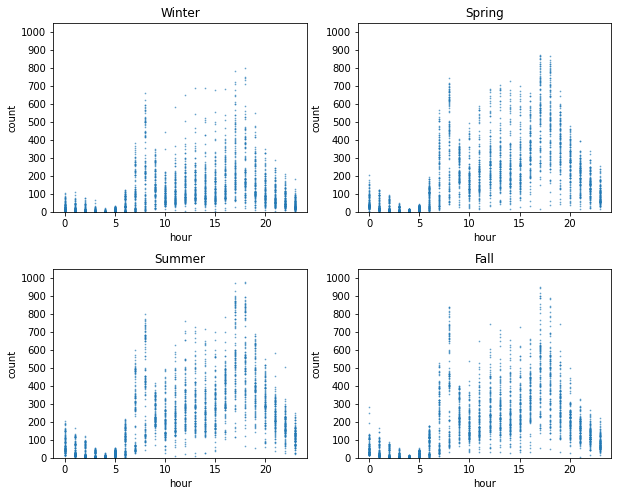

In [ ]:
plt.subplots(2,2, figsize=(10,8))
plt.subplots_adjust(hspace = 0.3)
season_dict = {1:"Winter", 2:"Spring", 3:"Summer", 4:"Fall"}
for idx, season in enumerate(train["season"].unique()):
    plt.subplot(2,2,idx+1)
    plt.scatter(x="hour", y="count", s=0.5, alpha=0.6, data=train[train["season"] == season])
    plt.title(f"{season_dict[season]}"); plt.xlabel("hour"); plt.ylabel("count")
    plt.ylim(0,1050); plt.yticks(np.arange(0, 1050, 100))

The hour-count scatter plot has 2 modes during the day, and decreases during the night. All the scatterplots between count and hour seems to have similar shape, although counts are much lower in the winter. This aligns with our findings at (b).

**e. Distribution of hourly rentals in 2011 and 2022**

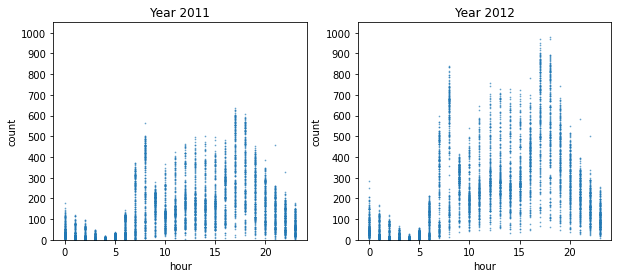

In [ ]:
plt.subplots(1,2, figsize=(10,4))
for idx, year in enumerate(train["year"].unique()):
    plt.subplot(1,2,idx+1)
    plt.scatter(x="hour", y="count", s=0.5, alpha=0.6, data = train[train["year"] == year])
    plt.title(f"Year {year}"); plt.xlabel("hour"); plt.ylabel("count")
    plt.ylim(0,1050); plt.yticks(np.arange(0, 1050, 100))

The shape of the scatter plot seems to be similar in both 2011 and 2012. However, the counts of the rentals in 2012 is much higher than in 2011. This shows that the rental business has grown in 2012. 

### Question 2

**2.1 Data Preprocessing**

Before building any models, we will check for any outliers/abnormal data points. From the summary statistics and histogram/scatter plot of each predictor, we see that there are some data that have zero humidity, which is impossible in regions like DC. Also, we see that there are a few rows that have unusually large differences (10~20 Celsius) between atemp and temp. The abnormal data was recorded on the same day, so it’s likely that there are some issues in the recordings that day. Since these data are only a small fraction of our training data, we decided to remove them(some teammates also tried to impute the data by linear regression or KNN based on other predictors). There are some data that have 2.5, 3.5 values for `weather`, but it’s possible that during these days the weather conditions are between level 2,3, or 4. So we keep them in our dataset. 

We also notice that all the predictors are numerical. For tree-based models, it is OK to treat the qualitative predictors as numerical as the algorithm could split the predictors into unique groups if such a split meaningfully improves group homogeneity. For KNN, it is OK to treat the qualitative predictors as numeric in this case because they are ordinal.

In [ ]:
train.describe()

,daylabel,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000,10932.000000
mean,359.791438,2011.500549,6.506037,9.991218,11.506586,2.501647,0.028540,0.681668,1.419502,20.190850,23.610814,61.905461,12.801018,190.768020
std,210.870086,0.500023,3.449289,5.474061,6.922500,1.117593,0.166517,0.465850,0.634532,7.807489,8.492816,19.260706,8.163840,181.187809
min,1.000000,2011.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000
25%,182.000000,2011.000000,4.000000,5.000000,6.000000,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,41.000000
50%,366.000000,2012.000000,7.000000,10.000000,12.000000,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,144.000000
75%,548.000000,2012.000000,10.000000,15.000000,18.000000,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,283.000000
max,719.000000,2012.000000,12.000000,19.000000,23.000000,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,977.000000


In [ ]:
#check for missing values
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


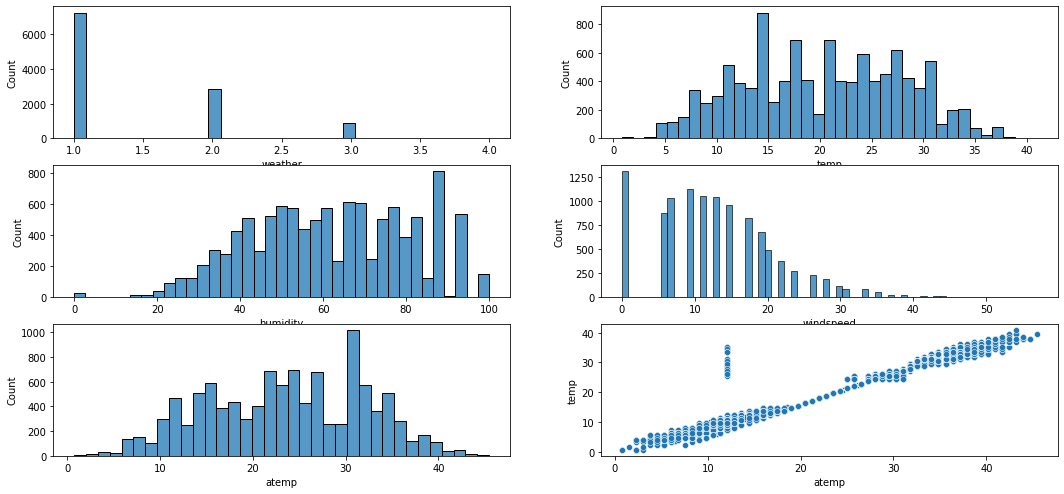

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(18,8.27))
sns.histplot(ax = axes[0,0],
             x='weather',
             data=train)
sns.histplot(ax = axes[0,1],
             x='temp',
             data=train)
sns.histplot(ax = axes[1,0],
             x='humidity',
             data=train)
sns.histplot(ax = axes[1,1],
             x='windspeed',
             data=train)
sns.histplot(ax = axes[2,0],
             x='atemp',
             data=train)
sns.scatterplot(ax = axes[2,1],
             x='atemp',
             y='temp',
             data=train)


Text(0, 0.5, 'Humidity')

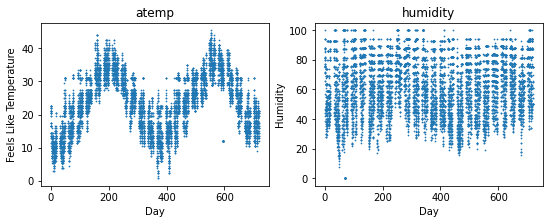

In [ ]:
plt.subplots(1,2,figsize=(9,3))
plt.subplot(1,2,1); plt.scatter(x="daylabel", y="atemp", data=train, s = 0.5)
plt.title("atemp"); plt.xlabel("Day"); plt.ylabel("Feels Like Temperature")
plt.subplot(1,2,2); plt.scatter(x="daylabel", y="humidity", data=train, s=0.5)
plt.title("humidity"); plt.xlabel("Day"); plt.ylabel("Humidity")

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# delete abnormal value
train1=train.drop(train.index[10476:10500])
train1=train.drop(train.index[936:960])

label1 = le.fit_transform(train1['year'])
train1['year_code'] = label1

**2.2 Feature Engineering**   
When we are experimenting with different models and tuning strategies, we found that feature engineering could lead to high improvements on our models compared to parameter tuning (maybe because we only have a few predictors). As for our tree-related models, we have found that the following manipulations of features is helpful:   
**Creating New Features**
#### 1. Weather of the previous hour
Idea: People usually choose their transportation tools ahead of time, so weather in the previous hour could be a better predictor than weather in the current hour. Also, when considering rainy weather, if the rain just begins, then people may still choose riding a bike. In contrast, if it has been raining for some time, then people may choose subway or other transportation.
#### 2. Indicator for the bad weather(weather = 3, 4) * humidity
Idea: Bad weather and humidity would both badly affect the rental rate, but if they are both bad, it wouldn't make things worse (bad enough). Thus, we would like to add this interaction variable to better capture this difference. 
#### 3. Interaction between working day and hour
Idea: From plot of count, hours, and working day, we see that there are some interaction effects.

More discussions on interactions: Even though random forest has been claimed to be able to capture interactions without specifying the interaction ourselves, we find that creating interactions could greatly improve our model performance. Some paper also discussed this issue (reference: Do little interactions get lost in dark random forests? https://link.springer.com/article/10.1186/s12859-016-0995-8). We think that adding interactions mannually may reduce the splits needed for tree-based models, which increases the efficiency. Also, when we randomly select features for trees, the interactions may not be able to be captured if the predictors are in different trees. Thus, interaction could help improve our models.

#### 4. Weekdays
Idea: From our observations in real life, we think there may be some variations in demands for bike-riding between weekdays. For instance, the traffic is more crowded on Mondays, so there may be more people choose to ride bikes. So we further label our data based on their weekdays. After we make boxplots, we do see higher demands on Mondays, and there may also be an interaction between weekday and weather. 

**Removing Features**   
In our boosting model, we have dropped predictors `daylabel`, `day`, `temp` because we know that train data only include the first 20 days of each month while test data include the rest days. They are highly separated, so the day-related variables do not provide much values for our predictions. From the previous scatterplot, we also see that `atemp` and `temp` are highly correlated (correlation ~1). Even though multicollinearity does not impact tree-related models as seriously as linear models, but it may add some noise or variations to our trees. 

In [ ]:
train1_reidx = train1.sort_values(by = ["daylabel", "hour"]).reset_index().drop(columns = "index")
train1_reidx['weather_pre']=train1_reidx['weather'].shift(+1)
train1_reidx['workingday_hour']=train1_reidx['hour']*train1_reidx['workingday']
train1_reidx['weather_hum']=pd.cut(train1_reidx['weather'],bins=[0,2,5],labels=[0,1])
train1_reidx['weather_hum']=pd.to_numeric(train1_reidx['weather_hum'])*train1_reidx['humidity']
train1_reidx=train1_reidx.dropna()
train1_reidx.head()

,daylabel,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year_code,weather_pre,workingday_hour,weather_hum
1,1,2011,1,1,1,1,0,0,1.0,9.02,13.635,80.0,0.0000,40,0,1.0,0,0.0
2,1,2011,1,1,2,1,0,0,1.0,9.02,13.635,80.0,0.0000,32,0,1.0,0,0.0
3,1,2011,1,1,3,1,0,0,1.0,9.84,14.395,75.0,0.0000,13,0,1.0,0,0.0
4,1,2011,1,1,4,1,0,0,1.0,9.84,14.395,75.0,0.0000,1,0,1.0,0,0.0
5,1,2011,1,1,5,1,0,0,2.0,9.84,12.880,75.0,6.0032,1,0,1.0,0,0.0


**2.3 Model Selection**

After engineering several features from the data, we tried fitting KNN, decision trees (using bagging), random forest, and gradient boosting models to the training data. For each model, we tuned the model using different hyperparameters and subsets of features. We selected the best model based on lowest CV RMSE.

Based on our analysis, we found that a Bagging model (using decision trees) resulted in the lowest prediction error. Below, we comment on the various methods we tried.

#### KNN
KNN resulted in the largest CV RMSE. We believe this is due to the fact that KNN effectively weights all covariates in the model equally when making predictions. For example, even if hour of the day is a stronger predictor of rentals than season is, a KNN prediction will be based on a Euclidean distance that weights the `season` and `hour` the same (after normalizing). Tree-based models are able to better account for the fact that some features may be stronger predictors of rentals than others. 

#### Random Forest
When we are building a Random Forest Regressor, we find that there are many parameters. It would be time-consuming if we tried to find the optimal values for each of them. Thus, we did some background research and found that in the paper "Hyperparameters and Tuning Strategies for Random Forest"(https://arxiv.org/pdf/1804.03515.pdf) the author summarized the performance of different tuning methods. He suggested that tuning the number of trees (‘n_estimators’ in sklearn.RandomForestRegressor) has the highest impact on model performance. Therefore, we tuned this parameter first. Based on the paper, sample size has minor influence but is worth tuning. We also learned in class that in order to avoid over-fitting, ‘ccp_alpha’ should be tuned since it’s pruning the tree by recursively finding and removing nodes with the “weakest link”. Another critical aspect is the number of features considered for each split, which is essentially how a random tree is different from bagging. For tuning these parameters, we use grid search cross-validation to explore every combination of the possible values. One drawback of random forest is that the time of tuning and fitting is quite long compared to other methods. 

#### Boosting


In the appendix, we show the code used to select and fit the best Boosting model and replicate our final submitted analysis. Our approach was as follows:

1) If first transformed y into log(y+1), and then made a prediction on log(y+1), and then transformed it by applying exp(ŷ)-1 to make sure that the final predicted value is positive. Boosting minimizes error terms to make a prediction, so it's possible that the predicted values are negative even the original data only has positive values.

2) Imputed the abnormal atemp values using linear regression. Used temp which is highly correlated to atemp. Imputed the abnormal humidity values using KNN regressor.

3) First, divide the train data into the training set and the validation set. Fit the boosting model with different number of trees (100 ~ 3000) and different learning rate(0.01 ~ 0.2) using the training set.

4) For each model, we calculate the MSE on the validation set and find the best perfomed model.

5) Using the parameters found at step 3, fit the model with all the train data (training set + validation set). Then make a prediction.

6) We did the same process with many different subsets of features, but we achieved the lowest prediction error using the following features: 'year', 'month', 'hour', 'season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', and  weather of a previous day, and interaction term between indicator of bad weather and 'humidity'.


#### Bagging

In the appendix, we show the code used to select and fit the best bagging model and replicate our final submitted analysis. Our approach was as follows:

1) Fit a bagging model with different numbers of trees. We tried 10, 50, 100, 500, and 1000 trees. 

2) For each model, calculate the CV RMSE. We subsequently chose the number of trees based on which model had the lowest CV RMSE. We found that the model with 1000 trees performed best.

3) Using a model with 1000 trees, we then tuned the parameter controlling the proportion of training samples to use for each tree. A bagging model that does not train on all samples may reduce overfitting because there will be less correlation between each tree, thereby making the predictions from each tree less dependent on each other. We find that the bagging model performs best when we use 60% of the training samples in model fitting. 

4) We did the same process with many different subsets of features, but we achieved the lowest prediction error using the following features: `year`, `hour`, `season`, `workingday`, `weather`, `atemp`, `humidity`, `windspeed`, `windspeed` from previous hour, interaction term between `workingday` and `hour`, and interaction term between `weather` and `humidity`.

5) After finding that the best bagging model uses 1000 trees and uses on 60% of the training data in each tree, we fit our final model and make predictions on the test set.

**3 Code Appendix for Replication**

**3.1 Submitted Boosting Model**

In [ ]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
## read data
url = 'https://raw.githubusercontent.com/matthewyang123/Booth-ML/main/Bike_test.csv'
test = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/matthewyang123/Booth-ML/main/Bike_train.csv'
train = pd.read_csv(url)
data = pd.concat([train, test], axis = 0)

In [ ]:
data = data.sort_values(["daylabel", "hour"]).reset_index().drop(columns = "index")
data["prev_weather"] = data.shift(1,fill_value = data.loc[0,"weather"]).loc[:,["weather"]]

In [ ]:
data["is_bad"] = data["weather"].isin([3,4])
data["is_bad"] = data["is_bad"].astype(int)

In [ ]:
data["bad_humid"] = data["is_bad"] * data["humidity"]

In [ ]:
data_train = data[data["day"] < 20]
data_test = data[data["day"] >= 20]

In [ ]:
# Impute the abnormal values 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

In [ ]:
data_temp = data_train[~(data_train["daylabel"] == 595)]["temp"].to_frame()
data_atemp = data_train[~(data_train["daylabel"] == 595)]["atemp"]
data_temp_pred = data_train[(data_train["daylabel"] == 595)]["temp"].to_frame()
ols = LinearRegression().fit(data_temp, data_atemp)
data_atemp_pred = ols.predict(data_temp_pred)
data_train.loc[(data["daylabel"] == 595),"atemp"] = data_atemp_pred

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
predict_values = ["hour", "season", "weather", "temp", "windspeed"]
abnormal_humid = data_train["humidity"] == 0
data_predictors = data_train.loc[~abnormal_humid, predict_values]
data_humid = data_train.loc[~abnormal_humid, "humidity"]
data_pred = data_train.loc[abnormal_humid, predict_values]
col_names = data_predictors.columns
data_predictors = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_predictors), columns = col_names)

In [ ]:
MSEs = []; kseq = np.arange(5,100,5)
for k in kseq:
    knn = KNeighborsRegressor(n_neighbors = k)
    mse = cross_val_score(knn, data_predictors, data_humid, cv = 10, scoring = "neg_mean_squared_error").mean()
    MSEs.append(mse)

In [ ]:
knn = KNeighborsRegressor(n_neighbors = kseq[np.argmax(MSEs)]).fit(data_predictors, data_humid)
data_humid_pred = knn.predict(data_pred)
data_train.loc[data_train["daylabel"] == 69, "humidity"] = data_humid_pred

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
## Divide the data into X and Y. 
x_train = data_train.loc[:,data_train.columns != "count"]
y_train = data_train.loc[:,"count"]

In [ ]:
## Select the features
del_col = ["daylabel", "day","temp", "is_bad"]
x_train = x_train.drop(columns = del_col)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=123)

In [ ]:
# Test the different parameters
n_estimators = [500, 1000, 1500, 2000]
learning_rates = [0.05, 0.1, 0.15, 0.2, 0.3]
MSE = []
for n in n_estimators:
    MSE.append([])
    for rate in learning_rates:
        GBR = GradientBoostingRegressor(n_estimators=n, learning_rate=rate).fit(x_train, np.log(y_train + 1))
        y_pred = np.exp(GBR.predict(x_valid))-1
        mse = mean_squared_error(y_valid, y_pred).mean()
        MSE[-1].append(mse)

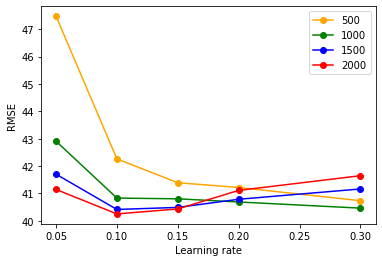

The minimum MSE is 40.736459701648855 for n/alpha 500/0.3
The minimum MSE is 40.4643874792474 for n/alpha 1000/0.3
The minimum MSE is 40.41589538910453 for n/alpha 1500/0.1
The minimum MSE is 40.25323450380295 for n/alpha 2000/0.1


In [ ]:
colors = ["orange", "green", "blue","red"]
for idx,n in enumerate(n_estimators):
    plt.plot(learning_rates, np.sqrt(MSE[idx]), marker = "o", color = colors[idx])
plt.xlabel("Learning rate"); plt.ylabel("RMSE")
plt.legend(n_estimators)
plt.show()

for idx, n in enumerate(n_estimators):
    minidx = np.argmin(MSE[idx])
    print(f"The minimum MSE is {np.sqrt(MSE[idx][minidx])} for n/alpha {n}/{learning_rates[minidx]}") 

In [ ]:
## Train the model with choosen features and parameters
## The MSE is bit different. Maybe due to the randomness choosing the training/validation set. We used the parameter n = 1500, learning rate = 0.2 though it's not the best in this document.
del_res = ["daylabel", "day","temp", "is_bad", "count"]
x_test = data_test.drop(columns = del_res)
x_test.describe()
GBR = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.2).fit(x_train, np.log(y_train + 1))
pred_res = np.exp(GBR.predict(x_test))-1

In [ ]:
## Produce the output
submission = pd.DataFrame(data={'Id':np.arange(1,len(x_test)+1),'count':pred_res})
submission.to_csv('my_submission.csv',index = False)

**3.2 Submitted Bagging Model**

In [ ]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from math import sqrt

In [ ]:
## read in data
url = 'https://raw.githubusercontent.com/matthewyang123/Booth-ML/main/Bike_test.csv'
test = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/matthewyang123/Booth-ML/main/Bike_train.csv'
train = pd.read_csv(url)

In [ ]:
## data preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# delete abnormal value
train1=train.drop(train.index[10476:10500])
train1=train.drop(train.index[936:960])

label1 = le.fit_transform(train1['year'])
train1['year_code'] = label1

In [ ]:
## feature engineering
train1_reidx = train1.sort_values(by = ["daylabel", "hour"]).reset_index().drop(columns = "index")
train1_reidx['weather_pre']=train1_reidx['weather'].shift(+1)
train1_reidx['workingday_hour']=train1_reidx['hour']*train1_reidx['workingday']
train1_reidx['weather_hum']=pd.cut(train1_reidx['weather'],bins=[0,2,5],labels=[0,1])
train1_reidx['weather_hum']=pd.to_numeric(train1_reidx['weather_hum'])*train1_reidx['humidity']
train1_reidx=train1_reidx.dropna()

In [ ]:
## parameter tuning (~10 mins)
X=train1_reidx[['year_code','hour','season','workingday','weather','atemp','humidity','windspeed','weather_pre','workingday_hour','weather_hum']]
RMSE=[]
# select number of trees
n_trees = [10, 50, 100, 500, 1000]
for n in n_trees:
    model = BaggingRegressor(random_state = 0,n_estimators=n)
    cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
    n_scores =abs(cross_val_score(model, X, train1_reidx['count'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    rmse=sqrt(n_scores.mean())
    RMSE.append(rmse)


In [ ]:
best_num_tree=n_trees[RMSE.index(min(RMSE))]
best_num_tree=1000
print("The optimal number of tree is ",best_num_tree)
print("The minimum RMSE for training dataset is ",min(RMSE))

The optimal number of tree is  1000
The minimum RMSE for training dataset is  44.10521231804404


In [ ]:
RMSE

[46.57172701842589,
 44.64075135189384,
 44.35184737656637,
 44.1268762082985,
 44.10521231804404]

In [ ]:
RMSE1=[]
# select sample size (~20 mins)
num_sample=np.arange(0.1, 1.1, 0.1)
for i in num_sample:
    model = BaggingRegressor(random_state = 0,n_estimators=best_num_tree,max_samples=i)
    cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
    n_scores =abs(cross_val_score(model, X, train1_reidx['count'], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    rmse=sqrt(n_scores.mean())
    RMSE1.append(rmse)

In [ ]:
best_num_sample=num_sample[RMSE1.index(min(RMSE1))]

print("The optimal sample size is ",best_num_sample)
print("The minimum RMSE for training dataset is ",min(RMSE1))

The optimal sample size is  0.6
The minimum RMSE for training dataset is  43.54786610778132


In [ ]:
RMSE1

[51.58555658236968,
 45.952848912308056,
 44.34463713328762,
 43.77662630830366,
 43.60861171937913,
 43.54786610778132,
 43.64753557182867,
 43.80039083197985,
 43.92084754085809,
 44.10521231804404]

In [ ]:
# preprocessing testing data
test1=test
label2 = le.fit_transform(test['year'])
test1['year_code'] = label2

test1_reidx = test1.sort_values(by = ["daylabel", "hour"]).reset_index().drop(columns = "index")
test1_reidx['weather_pre']=test1_reidx['weather'].shift(+1)
test1_reidx['weather_pre']=test1_reidx['weather_pre'].fillna(test1_reidx.loc[0]['weather'])
test1_reidx['workingday_hour']=test1_reidx['hour']*test1_reidx['workingday']
test1_reidx['weather_hum']=pd.cut(test1_reidx['weather'],bins=[0,2,5],labels=[0,1])
test1_reidx['weather_hum']=pd.to_numeric(test1_reidx['weather_hum'])*test1_reidx['humidity']



In [ ]:
best_model = BaggingRegressor(random_state = 0 ,n_estimators=best_num_tree,max_samples=best_num_sample)
best_model.fit(X, train1_reidx['count'])
test2=test1_reidx[['year_code','hour','season','workingday','weather','atemp','humidity','windspeed','weather_pre','workingday_hour','weather_hum']]
pred=best_model.predict(test2)


In [ ]:
import csv

id=np.arange(6493)+1
rows = zip(id,pred)
fields =['Id','count']
with open('sampleSubmission.csv', 'w') as csvfile: 
    csvwriter = csv.writer(csvfile,lineterminator='\n')  
    csvwriter.writerow(fields) 
    csvwriter.writerows(rows)
